In [1]:
version()

'SageMath version 9.0, Release Date: 2020-01-01'

Simulation of a Markovian SIR epidemic on a Simplicial Complex of arbitrary dimension

In [2]:
import networkx as nx

import random
import numpy as np

import matplotlib.pyplot as plt

In [3]:
random.seed(7)

In [4]:
np.random.seed(3)

In [5]:
def simplices_containing_node(node, scomplex, dim):
    "Returns list of all simplices of dimension dim having node as element"
    return [simplex for simplex in scomplex.faces()[dim] if node in simplex]

In [6]:
def node_neighborhood(node, scomplex):
    "Returns nodes that have an edge (1-simplex) connecting them to node"
    edges = simplices_containing_node(node, scomplex, 1)
    
    nodes = list(set([i for i, j in edges] + [j for i, j in edges]))
    
    nodes.remove(node)
    
    return(nodes)

In [7]:
def vertex_set(scomplex):
    "Returns vertex set of simplicial complex (0-simplices)"
    vertices = [i[0] for i in scomplex.faces()[0]]
    vertices.sort()
    
    return vertices

In [8]:
def infected_in_simplex(simplex, node_status):
    "Returns list of nodes in simplex with status 'I' (infected)"
    return len([node_status[i] for i in simplex if node_status[i] == 'I'])

### Description of the process

A contagion process will spread in a simplicial complex $X$ of dimension $d$. Nodes (i.e., 0-simplices) will be either susceptible, infectious or recovered. Susceptible nodes can turn infectious, and infectious node eventually recover. At time 0, a randomly selected node is turned infectious, while the rest are susceptible. A $k$-simplex $\mathcal{K}$ having all its nodes infected will infect a susceptible node $x$ according to a Poisson process with rate $\beta_{k+1}$ if $\mathcal{K} \cup \lbrace x \rbrace$ is a $k+1$ simplex in the complex.

In [9]:
def process_recovery(event, X, times, S, I, R, node_status):
    #events are (0: time, 1: simplex, 2: type)
    
    #Change the node status to R since its recovered
    node_status[event[1]] = 'R'
    
    #Add the time of occurence of the event to our array of times
    times.append(event[0])
    
    #We now have the same amount of Susceptibles, one infected less
    #and one recovered more.
    S.append(S[-1])
    I.append(I[-1]-1)
    R.append(R[-1]+1)    

In [10]:
def process_contagion(event, X, times, S, I, R, list_of_events, beta, gamma, dim, nodes, sched_time_inf, sched_time_rec, node_status, T_MAX):
    #events are (0: time, 1: simplex, 2: type)

    #We first check if the node is susceptible. Else there's nothing to do
    
    if node_status[event[1]] == 'S':
        #If it is susceptible, we change it to infected and adjust our 
        #data arrays
        node_status[event[1]] = 'I'
        times.append(event[0])
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])
        
        #For the (now) infected node, we generate a time for its recovery
        #If said time falls within our simulation time horizon, we create
        #a 'recovery' event
        rec_time = event[0] + random.expovariate(gamma)
        
        if rec_time < T_MAX:
            new_event = (rec_time, event[1], 'recovery')
            sched_time_rec[event[1]] = rec_time
            
            list_of_events.append(new_event)
            list_of_events.sort()
            
        #We now generate infection times for all susceptible neighbors 
        #of the (now) infected node
        for target in node_neighborhood(event[1], X):
            if node_status[target] == 'S':
                inf_time = event[0] + random.expovariate(beta[0])
                
                #The susceptible neighbor (target) will be infected at inf_time 
                #if inf_time happens before the Infectious' node recovery time
                #and before the target's scheduled time of infection, and 
                #within the simulation horizon                
                if inf_time < min(rec_time, sched_time_inf[target], T_MAX):
                    new_event = (inf_time, target, 'contagion')
                    list_of_events.append(new_event)
                    list_of_events.sort()
                    sched_time_inf[target] = inf_time
        
        #Here we will deal with 'simplicial contagion'; a simplex of dimension >= 1
        #infecting a node. Above we dealt with nodes (0-simplices) infecting other nodes
        for d in range(2, dim+1): 
            #We obtain the simplices of dimension d containing our newly infected node
            Simplices = simplices_containing_node(event[1], X, d)
            
            #For a (d-1)-simplex to infect a node u, the node u and the (d-1) simplex must form a 
            #d simplex where all nodes except u are infected, and u is susceptible 
            Simplices = [simplex for simplex in Simplices if infected_in_simplex(simplex, node_status) == d]
            
            for simplex in Simplices:
                #Because of the above condition, there should be at most one susc. node
                susc_nodes = [i for i in simplex if node_status[i] == 'S']
                
                for susc_node in susc_nodes:
                    inf_time = event[0] + random.expovariate(beta[d-1])
                    infected_nodes_in_simplex = [i for i in simplex if node_status[i] == 'I'] #should be 'd' of them
                    rec_times = [sched_time_rec[i] for i in infected_nodes_in_simplex]
                    rec_time = min(rec_times)
                    
                    if inf_time < min(rec_time, sched_time_inf[susc_node], T_MAX):
                        new_event = (inf_time, susc_node, 'contagion')
                        list_of_events.append(new_event) 
                        list_of_events.sort()
                        sched_time_inf[susc_node] = inf_time

In [11]:
def simplicial_sir(X, beta, gamma, T_MAX):
    dim = X.dimension()
    if len(beta) != dim:
        raise ValueError("There must be as many transmission rates as the dimension of the complex")
        
    nodes = vertex_set(X)
       
    #Scheduled time of infection for each node
    sched_time_inf = {i:np.inf for i in nodes}

    #Scheduled time of recovery for each node
    sched_time_rec = {i:np.inf for i in nodes}

    #Node status (can be either S, I or R)
    node_status = {i:'S' for i in nodes}
    
    list_of_events = []
    times, S, I, R = [0], [len(nodes)], [0], [0]
    
    #Initial infected node
    u = np.random.choice(nodes)

    sched_time_inf[u] = 0

    #events are (0: time, 1: simplex, 2: type)
    event = (0, u, 'contagion')

    #Every time we add an event to our list, the list must be sorted by time
    #(python sorts tuples by lexicographically by default, apparently)
    list_of_events.append(event)
    list_of_events.sort()
    
    while(len(list_of_events) > 0):
        event = list_of_events.pop(0)
    
        if event[2]  == 'contagion':
            process_contagion(event, X, times, S, I, R, list_of_events, beta, gamma, dim, nodes, sched_time_inf, sched_time_rec, node_status, T_MAX)
        else:
            process_recovery(event, X, times, S, I, R, node_status)
    
    
    data = np.column_stack((times, S, I, R))
    
    return data

In [12]:
X = simplicial_complexes.RandomComplex(20, 4)

In [13]:
data = simplicial_sir(X, [1.1, 1.2, 1.4, 1.5], 2, 10)

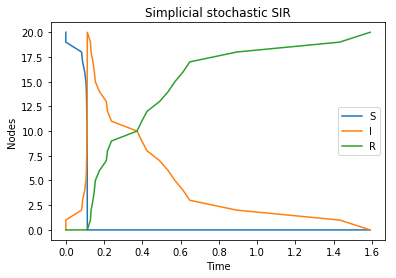

In [38]:
plt.plot(data[:, 0], data[:, 1], label='S')
plt.plot(data[:, 0], data[:, 2], label='I')
plt.plot(data[:, 0], data[:, 3], label='R')
plt.xlabel('Time')
plt.ylabel('Nodes')
plt.title("Simplicial stochastic SIR")
plt.legend()

******
*****
***********
### Example 2

In [14]:
G = nx.erdos_renyi_graph(500, .3)

In [15]:
nx.is_connected(G)

True

In [16]:
cliques = []

In [17]:
#This takes about a minute
for clique in nx.enumerate_all_cliques(G):
    if len(cliques) < 3000:
        if len(clique) == 3:
            u = random.random()
            if u < .5:
                cliques.append(clique)
    else:
        break

In [18]:
cliques = [(x[0], x[1], x[2]) for x in cliques]

In [19]:
edges = [pair for pair in G.edges]

In [20]:
simplices = cliques + edges

In [21]:
from time import time

In [24]:
beg = time()

1620601741.333966

In [25]:
#This will take from 5 to 10 min depending on your machine
beg = time()
X = SimplicialComplex(simplices)
dur = time()-beg

In [26]:
dur

259.8828308582306

In [29]:
#Dimension of simplicial complex where the contagion process will occur
dim = X.dimension()

In [30]:
dim

2

In [33]:
beta, gamma = [.5, 1], 2

In [34]:
data = simplicial_sir(X, beta, gamma, 10)

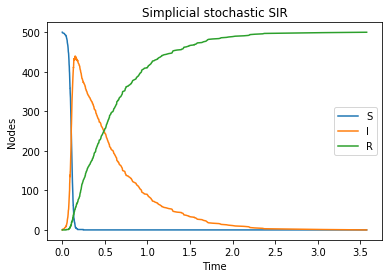

In [35]:
plt.plot(data[:, 0], data[:, 1], label='S')
plt.plot(data[:, 0], data[:, 2], label='I')
plt.plot(data[:, 0], data[:, 3], label='R')
plt.xlabel('Time')
plt.ylabel('Nodes')
plt.title("Simplicial stochastic SIR")
plt.legend()